In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import polars as pl
from icecream import ic
from matplotlib import pyplot as plt
from polars import col

from src.data.database_manager import DatabaseManager
from src.data.quality_checks import check_sample_rate
from src.features.resampling import add_time_column, add_timestamp_µs_column
from src.features.scaling import scale_min_max
from src.features.transforming import map_participants, map_trials
from src.log_config import configure_logging
from src.plots.plot_modality import plot_modality_over_trials

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG, ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"]
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    df = db.get_table("raw_stimulus")
df = add_time_column(df)
df.hvplot(x="time", y="temperature", groupby=["participant_id", "trial_number"])

BokehModel(combine_events=True, render_bundle={'docs_json': {'dfcbf103-93e7-460c-9ab6-aac2ddec4407': {'version…

In [5]:
@map_trials
def decimate(
    df: pl.DataFrame,
    factor: int = 10,
) -> pl.DataFrame:
    """Decimate all float columns by a factor of 10.

    This function applies scipy.signal.decimate to all float columns in the DataFrame
    and gathers every 10th row for all other columns.
    """

    def decimate_column(col):
        if col.dtype in [pl.Float32, pl.Float64]:
            return pl.from_numpy(
                signal.decimate(
                    col.to_numpy(),
                    factor,
                    ftype="iir",
                )
            ).to_series()
        else:
            return col.gather_every(10)

    return df.select(pl.all().map_batches(decimate_column))


df = decimate(df)


thread '<unnamed>' panicked at crates/polars-python/src/dataframe/general.rs:356:31:
UDF failed: NameError: name 'signal' is not defined
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: UDF failed: NameError: name 'signal' is not defined

In [8]:
df.hvplot(x="time", y="rating", groupby=["trial_id"])

BokehModel(combine_events=True, render_bundle={'docs_json': {'a4068348-eeae-4a6c-90a5-62c70bb939cc': {'version…

In [25]:
df

trial_id,trial_number,participant_id,rownumber,timestamp,temperature,rating,time
u16,u8,u8,u32,f64,f64,f64,duration[ms]
1,1,1,0,290836.153318,45.224758,42.660354,4m 54s 224ms
1,1,1,10,291881.091755,45.235349,45.990028,4m 55s 261ms
1,1,1,20,292863.224662,45.265408,71.160729,4m 56s 260ms
1,1,1,30,293854.06379,45.313314,65.174978,4m 57s 263ms
1,1,1,40,294852.941015,45.381109,66.602879,4m 58s 261ms
1,1,1,50,295830.895198,45.460249,68.291577,4m 59s 262ms
…,…,…,…,…,…,…,…
332,12,28,21561,2.7404e6,45.520961,72.422329,46m 12s 122ms
332,12,28,21571,2.7414e6,45.40331,75.899436,46m 13s 123ms


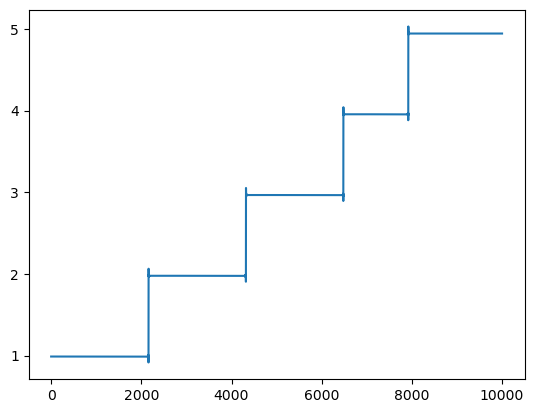

In [13]:
from scipy import signal

# q: int The downsampling factor. When using IIR downsampling, it is recommended to call decimate multiple times for downsampling factors higher than


da = signal.decimate(df["participant_id"], 10, ftype="iir")
plt.plot(da[:10000])

In [20]:
pl.from_numpy(da).to_series()

column_0
f64
0.988553
0.988553
0.988553
0.988553
0.988553
0.988553
…
27.679487
27.679487


In [15]:
type(da)

numpy.ndarray

In [16]:
da

array([ 0.98855309,  0.98855309,  0.98855309, ..., 27.67948665,
       27.67948665, 27.67948665])

In [23]:
with db:
    df = db.get_table("RAW_EDA")
df = add_timestamp_µs_column(df)
check_sample_rate(df)

12:08:58 | DEBUG   | quality_checks | Sample rate per trial: [ 97.89  98.81  98.71  98.69  98.84  98.98  98.52  98.75  98.61  98.9
  98.54  98.71 100.41 100.75 100.66 100.68 100.7  100.44 100.57 100.63
 100.69 100.48 100.68 100.37  99.03  99.    99.    98.93  99.23  98.69
  99.08  98.84  99.27  98.82  98.93  99.09  99.07  98.93  99.2   99.09
  99.23  99.11  99.31  98.88  98.73  98.78  98.69  98.78  98.52  98.78
  98.59  98.49  98.7   98.63  98.72  98.6   98.7   98.82  99.02  98.66
  98.65  98.63  98.92  98.97  98.9   98.81  98.9   98.85  99.17  99.14
  98.83  98.97  98.98  98.85  99.07  99.    98.79  98.75  98.76  98.7
  98.9   98.73  98.96  98.71  98.91  98.8   98.6   98.88  98.81  98.72
  98.74  98.63 100.51 100.54 100.5  100.51 100.67 100.65 100.65 100.57
 100.63 100.6  100.61 100.61  98.6   98.92  98.54  98.82  98.75  98.72
  98.69  98.85  98.63  98.82  98.57  98.54  98.93  98.83  98.93  98.93
  99.02  98.97  98.98  98.91  98.86  98.8   98.8   98.68  98.9   98.42
  98.72  98.95  98

In [17]:
check_sample_rate(df)

12:07:37 | DEBUG   | quality_checks | Sample rate per trial: [10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.
 10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.
 10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.
 10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.
 10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.   10.
 10.   10.   10.   10.   10.   10.   10.   10.   10.01 10.01 10.01 10.01
 10.01 10.01 10.01 10.01 10.   10.01 10.01 10.01 10.01 10.01 10.01 10.01
 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01
 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01
 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01
 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01
 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01
 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01 10.01


In [18]:
scale_min_max(df).plot(
    x="timestamp",
    y=["rating", "temperature"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'13a0ea2f-2b07-4b04-bc75-76d6c1a053f6': {'version…

In [6]:
data = df.filter([col("trial_id") == 1])

In [13]:
scale_min_max(df).plot(
    x="time",
    y=["rating", "temperature"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'76542f09-57ad-445d-8fae-730ed262bea3': {'version…

In [182]:
data["timestamp_µs"].is_sorted()

True